In [1]:
from pathlib import Path
from tqdm.autonotebook import tqdm
import json

import matplotlib.pyplot as plt
import cv2

from detectron2.structures.boxes import BoxMode

import sys
sys.path.append('../utils')

from train_eval import Evaluation

root_directory = Path("../data")
images_directory = root_directory / "images"
annots_directory =  root_directory / "annotations"
bbox_directory =  root_directory / "annotations-bbox"
masks_directory =  root_directory / "annotations-seg"

<ipython-input-1-d5fcb219b5e9>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Register Datasets

In [5]:
import os
import glob
import random
import remo

remo.connect()
remo.set_viewer('jupyter')
modanet_segmentation_dataset = remo.Dataset(id = 1, name = "modanet_segmentation_full", quantity=10)

In [9]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

path_to_train = annots_directory / 'modanet_instance_segmentation_train.json'
path_to_test = annots_directory / 'modanet_instance_segmentation_test.json'

register_coco_instances('modanet_instance_segmentation_train', {}, path_to_train, images_directory)
register_coco_instances('modanet_instance_segmentation_test', {}, path_to_test, images_directory)

MetadataCatalog.get('modanet_instance_segmentation_train').set(
    thing_classes=['bag', 'dress', 'footwear', 'skirt', 'top', 'sunglasses', \
                   'headwear', 'shorts', 'pants', 'belt', 'outer', 'scarf', 'boots']
)
train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')

## CenterMask

### Training

In [14]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.config import get_cfg
from detectron2 import model_zoo

import random
random.seed(600)

centermask_path = "../centermask2/configs/"
model_yaml_path = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
# model_weights_path = 'detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_yaml_path))
cfg.OUTPUT_DIR = '../logs/exploration_test'
cfg.DATASETS.TRAIN = ('modanet_instance_segmentation_train',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01

cfg.SOLVER.NUM_GPUS = 1
single_iteration = cfg.SOLVER.NUM_GPUS * cfg.SOLVER.IMS_PER_BATCH
iterations_for_one_epoch = len(dataset_dicts) / single_iteration
cfg.SOLVER.MAX_ITER = iterations_for_one_epoch * 2 # -> 2 epochs?   

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml_path)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

In [15]:
# from detectron2.engine import DefaultTrainer

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

### Evaluate

In [16]:
eval_tools = Evaluation(cfg, "modanet_instance_segmentation_test")

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (13, 256, 1, 

In [17]:
# eval_tools.run_coco_eval()

### Visualizations

In [18]:
# from detectron2.engine import DefaultPredictor

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4 # original 0.5
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set the testing threshold for this model
# cfg.DATASETS.TEST = ('modanet_instance_segmentation_test', )
# predictor = DefaultPredictor(cfg)

train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')
test_dataset_dicts = DatasetCatalog.get('modanet_instance_segmentation_test')

WARNING [08/11 20:00:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/11 20:00:37 d2.data.datasets.coco]: Loaded 10451 images in COCO format from ../data/annotations/modanet_instance_segmentation_test.json


/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool

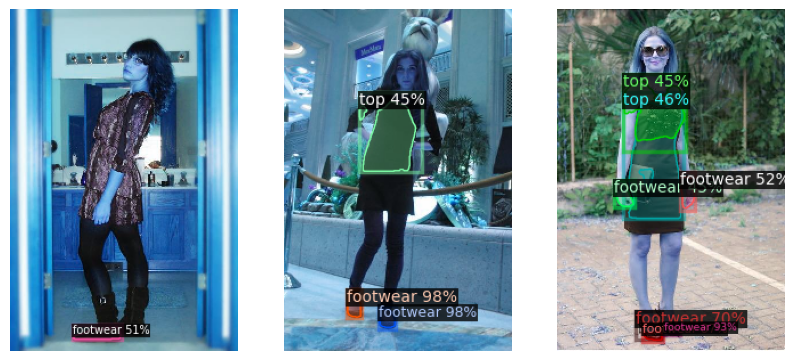

In [19]:
eval_tools.show_n(dataset_dicts=test_dataset_dicts, metadata=train_metadata, predictions = True)

In [20]:
mapping = {k: v for k, v in enumerate(train_metadata.thing_classes)}
mapping

{0: 'bag',
 1: 'dress',
 2: 'footwear',
 3: 'skirt',
 4: 'top',
 5: 'sunglasses',
 6: 'headwear',
 7: 'shorts',
 8: 'pants',
 9: 'belt',
 10: 'outer',
 11: 'scarf',
 12: 'boots'}

In [21]:
test_annots = eval_tools.createAnnots(test_dataset_dicts, mapping = mapping, sample_ratio=2)

100%|██████████| 5226/5226 [05:45<00:00, 15.13it/s]


In [23]:
# model_predictions = modanet_segmentation_dataset.create_annotation_set(
#     annotation_task = 'Instance Segmentation', name = 'exploration_preds_sampleratio2')

# modanet_segmentation_dataset.add_annotations(test_annots, annotation_set_id=model_predictions.id)

In [24]:
modanet_segmentation_dataset.view()

Open http://localhost:8123/datasets/1
